<a href="https://colab.research.google.com/github/tysonmasa/Naive-Bayes/blob/main/naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#preprocess data

import pandas as pd

df = pd.read_csv("data.csv")
df_sents = df.iloc[:, 1::2] #just get sentences

df_test = df_sents.iloc[-10:]  # Last 10 rows for testing
import nltk
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

text_columns = ["Sadness Sentences", "Joy Sentences", "Fear Sentences", "Anger Sentences", "Surprise Sentence", "Disgust Sentences", "Sadness + Joy Sentences", "Fear + Anger Sentences", "Surprise + Disgust Sentences", "Sadness + Joy + Fear Sentences"]
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return lemmatized

for column in text_columns:
    df_sents[column] = df_sents[column].apply(preprocess_text)

#split up data

df_train = df_sents.iloc[:30]  # First 30 rows for training
df_val = df_sents.iloc[30:40]  # Next 10 rows for validation


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-100-9173b7c8286d>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sents[column] = df_sents[column].apply(preprocess_text)


In [ ]:
display(df_train.iloc[0])

Sadness Sentences                 [devastating, news, child, abduction, left, so...
Joy Sentences                     [sunny, summer, morning, laughter, child, coul...
Fear Sentences                    [walked, dead, night, could, hear, sudden, foo...
Anger Sentences                   [driving, family, restaurant, car, recklessly,...
Surprise Sentence                 [startled, unexpectedly, everyone, sprang, hid...
Disgust Sentences                 [forgotten, take, trash, leaving, holiday, ret...
Sadness + Joy Sentences           [visited, old, childhood, home, felt, wave, bi...
Fear + Anger Sentences            [tom, fearful, bully, remained, docile, picked...
Surprise + Disgust Sentences      [opened, package, food, delivery, shocked, see...
Sadness + Joy + Fear Sentences    [parent, watched, son, leave, college, proud, ...
Name: 0, dtype: object


In [ ]:
# Calculate prior probs

total_examples = df_train.size + df_train["Sadness + Joy Sentences"].count() + df_train["Fear + Anger Sentences"].count() + df_train["Surprise + Disgust Sentences"].count() + df_train["Sadness + Joy + Fear Sentences"].count() + df_train["Sadness + Joy + Fear Sentences"].count()
print(total_examples)

#sadness:
sadcnt = df_train["Sadness Sentences"].count() + df_train["Sadness + Joy Sentences"].count() + df_train["Sadness + Joy + Fear Sentences"].count()
print(sadcnt)
prior_sadness = sadcnt / total_examples
print(prior_sadness)
#joy:
joycnt = df_train["Joy Sentences"].count() + df_train["Sadness + Joy Sentences"].count() + df_train["Sadness + Joy + Fear Sentences"].count()
print(joycnt)
prior_joy = joycnt / total_examples
print(prior_joy)
#fear:
fearcnt = df_train["Fear Sentences"].count() + df_train["Fear + Anger Sentences"].count() + df_train["Sadness + Joy + Fear Sentences"].count()
print(fearcnt)
prior_fear = fearcnt / total_examples
print(prior_fear)
#anger:
angercnt = df_train["Anger Sentences"].count() + df_train["Fear + Anger Sentences"].count()
print(angercnt)
prior_anger = angercnt / total_examples
print(prior_anger)
#surprise:
surprisecnt = df_train["Surprise Sentence"].count() + df_train["Surprise + Disgust Sentences"].count()
print(surprisecnt)
prior_surprise = surprisecnt / total_examples
print(prior_surprise)
#disgust:
disgustcnt = df_train["Disgust Sentences"].count() + df_train["Surprise + Disgust Sentences"].count()
print(disgustcnt)
prior_disgust = disgustcnt / total_examples
print(prior_disgust)

prior_probs = {"Sadness Sentences": prior_sadness, "Joy Sentences": prior_joy, "Fear Sentences": prior_fear, "Anger Sentences": prior_anger, "Surprise Sentence": prior_surprise, "Disgust Sentences": prior_disgust}

450
90
0.2
90
0.2
90
0.2
60
0.13333333333333333
60
0.13333333333333333
60
0.13333333333333333


In [ ]:
#calculate likelihoods of words given emotion category w/ laplace smoothing
#run all previous cells first

from collections import Counter

smooth = 1

word_counts = {}  # Store word counts per category
total_words = {}  # Store total word count per category
vocabulary = set()  # Global vocabulary set

#clac sadness:
all_words = []
for series in [df_train["Sadness Sentences"], df_train['Sadness + Joy Sentences'], df_train['Sadness + Joy + Fear Sentences']]:
    for item in series:
        if isinstance(item, list):  # Check if the item is a list
            all_words.extend(item)  # Extend the all_words list
word_counts["Sadness Sentences"] = Counter(all_words)
total_words["Sadness Sentences"] = sum(word_counts["Sadness Sentences"].values())
vocabulary.update(all_words)

#calc joy
all_words = []
for series in [df_train["Joy Sentences"], df_train['Sadness + Joy Sentences'], df_train['Sadness + Joy + Fear Sentences']]:
    for item in series:
        if isinstance(item, list):  # Check if the item is a list
            all_words.extend(item)
word_counts["Joy Sentences"] = Counter(all_words)
total_words["Joy Sentences"] = sum(word_counts["Joy Sentences"].values())
vocabulary.update(all_words)

#calc fear
all_words = []
for series in [df_train["Fear Sentences"], df_train['Fear + Anger Sentences'], df_train['Sadness + Joy + Fear Sentences']]:
    for item in series:
        if isinstance(item, list):  # Check if the item is a list
            all_words.extend(item)
word_counts["Fear Sentences"] = Counter(all_words)
total_words["Fear Sentences"] = sum(word_counts["Fear Sentences"].values())
vocabulary.update(all_words)

#calc anger
all_words = []
for series in [df_train["Anger Sentences"], df_train['Fear + Anger Sentences']]:
    for item in series:
        if isinstance(item, list):  # Check if the item is a list
            all_words.extend(item)
word_counts["Anger Sentences"] = Counter(all_words)
total_words["Anger Sentences"] = sum(word_counts["Anger Sentences"].values())
vocabulary.update(all_words)

#calc surprise
all_words = []
for series in [df_train["Surprise Sentence"], df_train['Surprise + Disgust Sentences']]:
    for item in series:
        if isinstance(item, list):  # Check if the item is a list
            all_words.extend(item)
word_counts["Surprise Sentence"] = Counter(all_words)
total_words["Surprise Sentence"] = sum(word_counts["Surprise Sentence"].values())
vocabulary.update(all_words)

#calc disgust
all_words = []
for series in [df_train["Disgust Sentences"], df_train['Surprise + Disgust Sentences']]:
    for item in series:
        if isinstance(item, list):  # Check if the item is a list
            all_words.extend(item)
word_counts["Disgust Sentences"] = Counter(all_words)
total_words["Disgust Sentences"] = sum(word_counts["Disgust Sentences"].values())
vocabulary.update(all_words)


#compute likelihoods

V = len(vocabulary)  # Size of the vocabulary
likelihoods = {}

categories = ["Sadness Sentences", "Joy Sentences", "Fear Sentences", "Anger Sentences", "Surprise Sentence", "Disgust Sentences"]

for col in categories:
    likelihoods[col] = {}
    for word in vocabulary:
        likelihoods[col][word] = (word_counts[col][word] + smooth) / (total_words[col] + smooth * V)

likelihoods_df = pd.DataFrame(likelihoods)

print(likelihoods_df)


            Sadness Sentences  Joy Sentences  Fear Sentences  Anger Sentences  \
cowardly             0.000317       0.000311        0.000314         0.000375   
memory               0.002533       0.002489        0.001571         0.000750   
unbearable           0.000317       0.000311        0.000314         0.000375   
nyc                  0.000317       0.000311        0.000314         0.000375   
nauseated            0.000317       0.000311        0.000314         0.000375   
...                       ...            ...             ...              ...   
barking              0.000317       0.000311        0.000314         0.000750   
unable               0.000633       0.000622        0.000629         0.000750   
became               0.000633       0.000622        0.000629         0.000750   
townsfolk            0.000317       0.000311        0.000629         0.000375   
admitted             0.000633       0.000622        0.000629         0.000375   

            Surprise Senten

In [ ]:
# emotion prediction function

import numpy as np

likelihoods = likelihoods_df.to_dict()

def predict_emotion(text):
  words = text.lower().split()
  category_scores = {}

  for category in likelihoods.keys():
        log_prob = np.log(prior_probs[category])  #log prior probability

        # Only sum log probabilities of words that exist in the vocabulary
        for word in words:
            if word in likelihoods[category]:  # Ignore unknown words
                log_prob += np.log(likelihoods[category][word])

        category_scores[category] = log_prob  # Store final score for category

  print(category_scores)

  # Return category with the highest log probability
  return max(category_scores, key=category_scores.get)





In [ ]:
# use the function to predict the text
# run this after all the previous cells

test_text = "As she hugged her daughter goodbye on the first day of college, she felt both sad to see her go and joyful knowing that she was embarking on a new and exciting chapter in her life."

test_emotion = predict_emotion(test_text)
print(f"The predicted emotion is: {test_emotion}")


{'Sadness Sentences': -62.41363601671402, 'Joy Sentences': -63.07898807492788, 'Fear Sentences': -64.50405827129322, 'Anger Sentences': -68.33453145673768, 'Surprise Sentence': -67.48944704303209, 'Disgust Sentences': -68.37423204086207}
The predicted emotion is: Sadness Sentences


{'Sadness Sentences': -81.58538130171561, 'Joy Sentences': -82.87734445668431, 'Fear Sentences': -83.0549568177391, 'Anger Sentences': -83.13187101779697, 'Surprise Sentence': -83.4398931252436, 'Disgust Sentences': -84.66499134416706}
{'Sadness Sentences': -37.739025803152366, 'Joy Sentences': -39.78857106658516, 'Fear Sentences': -40.549469595802876, 'Anger Sentences': -41.460325055719835, 'Surprise Sentence': -41.333159347785525, 'Disgust Sentences': -39.95646744784632}
{'Sadness Sentences': -53.33116604901899, 'Joy Sentences': -53.30005682956483, 'Fear Sentences': -53.016438367468695, 'Anger Sentences': -55.159052328111024, 'Surprise Sentence': -54.98102033700299, 'Disgust Sentences': -53.89585149398785}
{'Sadness Sentences': -50.23007325980717, 'Joy Sentences': -52.53791677751793, 'Fear Sentences': -53.50194618325039, 'Anger Sentences': -54.348122111894696, 'Surprise Sentence': -54.57555522889483, 'Disgust Sentences': -53.20270431342791}
{'Sadness Sentences': -43.88717749308351, '

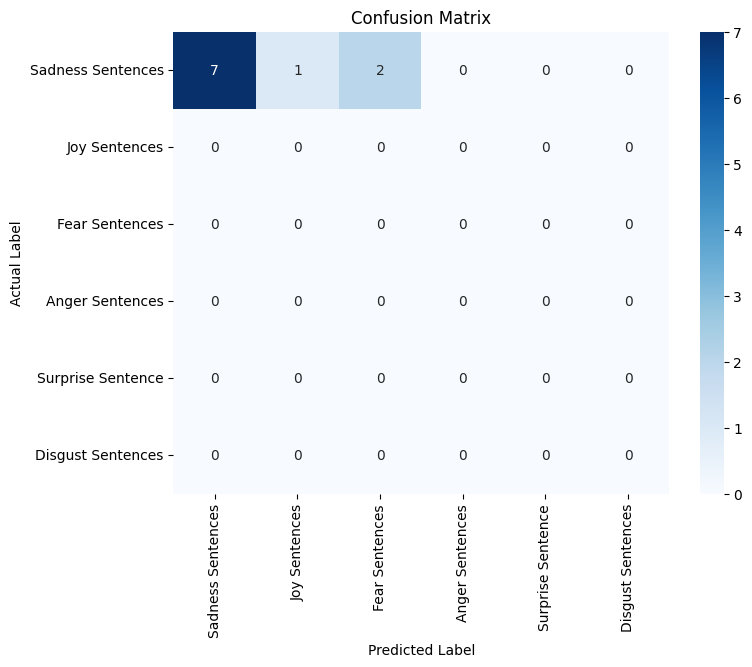

Classification Report:
                    precision    recall  f1-score   support

   Fear Sentences       0.00      0.00      0.00         0
    Joy Sentences       0.00      0.00      0.00         0
Sadness Sentences       1.00      0.70      0.82        10

         accuracy                           0.70        10
        macro avg       0.33      0.23      0.27        10
     weighted avg       1.00      0.70      0.82        10



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# evaluation ; not complete :(

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


df_test["actual_category"] = df_test.apply(lambda row: next(col for col in categories if row[col]), axis=1)
df_test["predicted_category"] = df_test.apply(lambda row: predict_emotion(row[row["actual_category"]]), axis=1)
#This line now passes just the text string to the predict_emotion function, after ensuring it's a string

# Compute confusion matrix
conf_matrix = confusion_matrix(df_test["actual_category"], df_test["predicted_category"], labels=categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(df_test["actual_category"], df_test["predicted_category"]))